# 6.6 Sourcing & Analyzing Time-Series Data

## This script contains the following:

#### 1. Importing your libraries and data

#### 2. Subsetting, wrangling, and cleaning time-series data

#### 3. Time series analysis: decomposition

#### 4. Testing for stationarity

#### 5. Stationarizing the Data

### 1. Importing your libraries and data

In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear. More examples here:
# https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html
# https://matplotlib.org/3.1.0/gallery/style_sheets/fivethirtyeight.html

In [2]:
# Configure API key
quandl.ApiConfig.api_key = 'wimyzuoCNy_QzZnCNwLy'

In [3]:
# Importing USA Consumer Price Index - this is the "whole value" (rather than the monthly change) calculation posted by Statistics Canada
# Note - I attempted to find a Real Estate data set relevant to my project, 
# however given the specificity of the Airbnb data for Vancouver, I chose to take a look at something else I'm interested in for this assignment!
data = quandl.get('RATEINF/CPI_USA')

In [5]:
data.head(5)

,Value
Date,
1913-01-31,9.8
1913-02-28,9.8
1913-03-31,9.8
1913-04-30,9.8
1913-05-31,9.7


In [6]:
data.shape

(1327, 1)

In [7]:
data.columns

Index(['Value'], dtype='object')

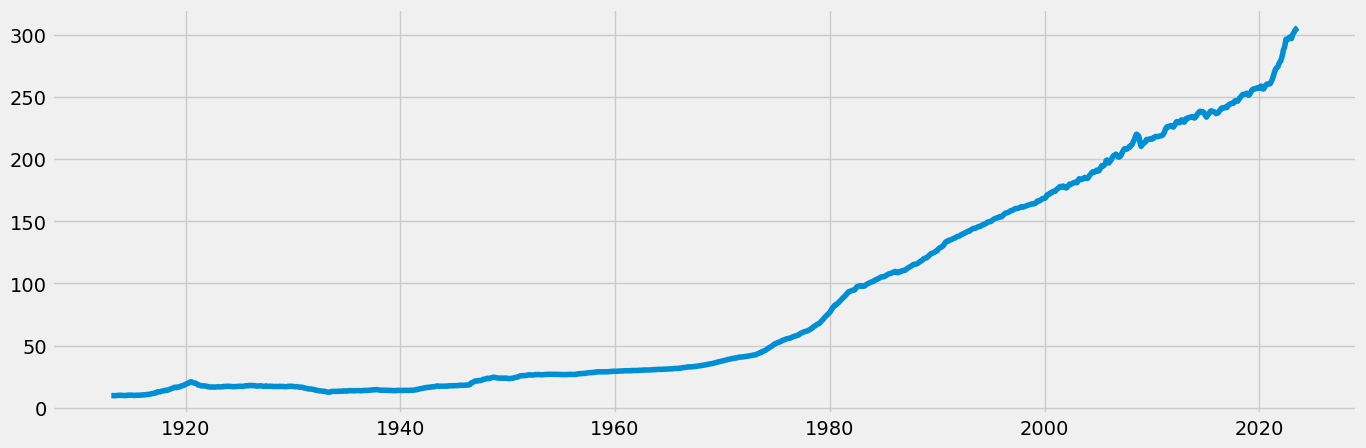

In [8]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) # The dpi argument controls the quality of the visualization here. When it's set to 100,
# it will produce lower-than-standard quality, which is useful if, similar to this notebook, you'll have a lot of plots.
# A large number of plots will increase the size of the notebook, which could take more time to load and eat up a lot of RAM!

plt.plot(data)

### 2. Subsetting, wrangling, and cleaning time-series data

In [9]:
# Reset index so that you can use the "Date" column as a filter

data_2 = data.reset_index()

In [10]:
data_2.head()

,Date,Value
0,1913-01-31,9.8
1,1913-02-28,9.8
2,1913-03-31,9.8
3,1913-04-30,9.8
4,1913-05-31,9.7


In [30]:
data_sub = data_2.loc[(data_2['Date'] >= '1980-01-01') & (data_2['Date'] < '2020-06-01')]


In [31]:
data_sub.shape

(485, 2)

In [32]:
data_sub.head()

,Date,Value
804,1980-01-31,77.8
805,1980-02-29,78.9
806,1980-03-31,80.1
807,1980-04-30,81.0
808,1980-05-31,81.8


In [33]:
# Set the "Date" column as the index

from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['Date']) # Create a datetime column from "Date.""
data_sub = data_sub.set_index('datetime') # Set the datetime as the index of the dataframe.
data_sub.drop(['Date'], axis=1, inplace=True) # Drop the "Date" column.
data_sub.head()

,Value
datetime,
1980-01-31,77.8
1980-02-29,78.9
1980-03-31,80.1
1980-04-30,81.0
1980-05-31,81.8


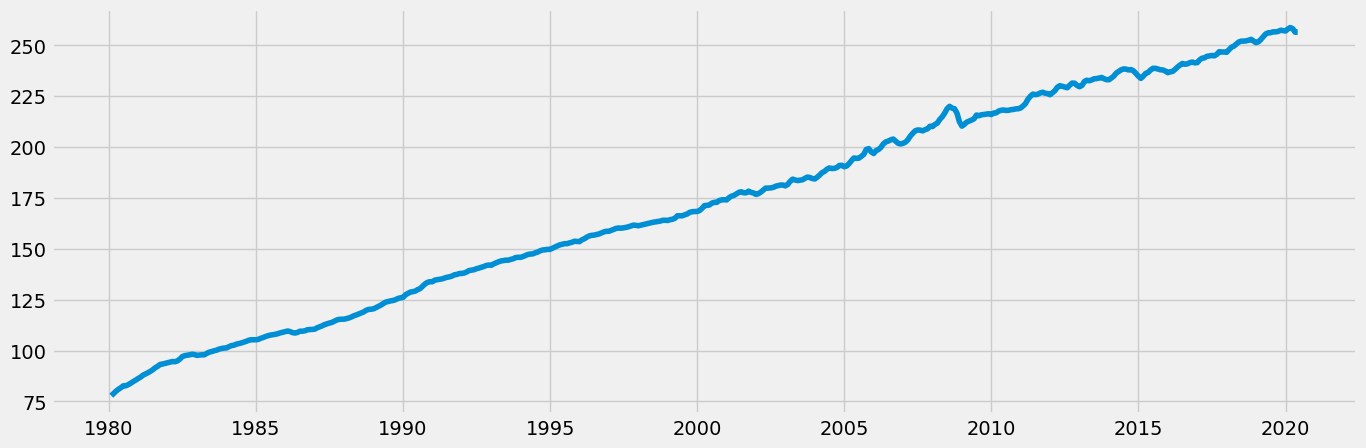

In [34]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

In [35]:
# Check for missing values (you shouldn't have any)

data_sub.isnull().sum() 

Value    0
dtype: int64

In [36]:
# Check for duplicates

dups = data_sub.duplicated()
dups.sum()

29

In [37]:
data_sub.duplicated()

datetime
1980-01-31    False
1980-02-29    False
1980-03-31    False
1980-04-30    False
1980-05-31    False
              ...  
2020-01-31    False
2020-02-29    False
2020-03-31    False
2020-04-30    False
2020-05-31    False
Length: 485, dtype: bool

In [38]:
data_sub.head(10)

,Value
datetime,
1980-01-31,77.8
1980-02-29,78.9
1980-03-31,80.1
1980-04-30,81.0
1980-05-31,81.8
1980-06-30,82.7
1980-07-31,82.7
1980-08-31,83.3
1980-09-30,84.0


#### Note: duplicated values are due to some values staying constant for at least a few months. I'll leave them for now since they are probably not 'duplicated' in the negative sense. I did shortened the subset to 1980-2020 and not from 1960-2020 to decrease the number of duplicated values and because 1980 is the year when inflation starts increasing (at least in the general picture).

### 3. Time-series analysis: decomposition

In [39]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive')

In [40]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

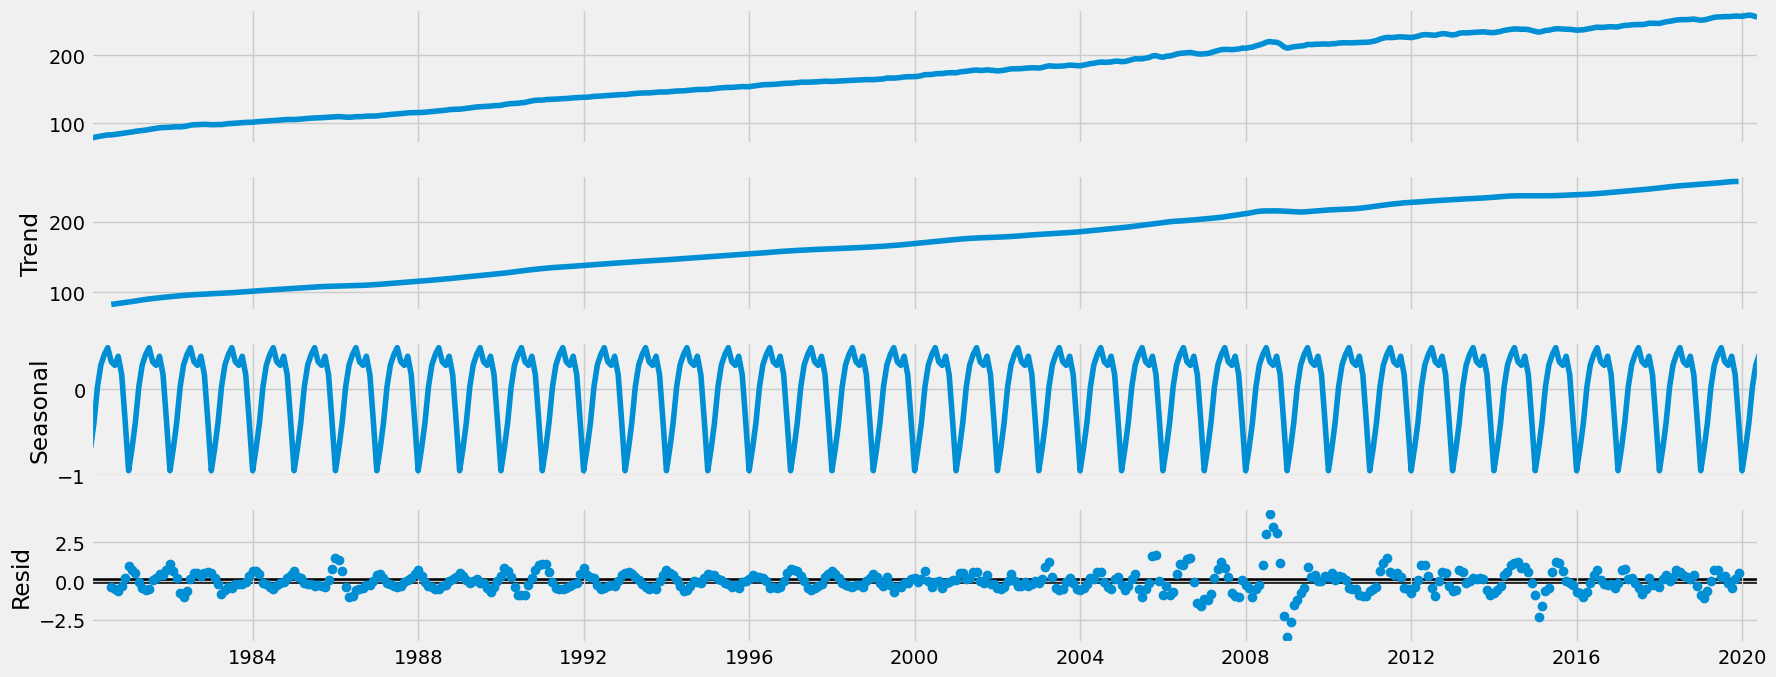

In [41]:
# Plot the separate components

decomposition.plot()
plt.show()

#### Note: the trend line seems linear, which does not require a smoothing process. Seasonality it is also present in the data, and regarding the residual we can see that from the 80's up to 2000 is fairly constant; the market crash of 2008 is very evident, along with different fluctuations of inflations afterwards.

### 4. Testing for stationarity¶

In [42]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why we need to define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                  -0.690373
p-value                          0.849227
Number of Lags Used             13.000000
Number of Observations Used    471.000000
Critical Value (1%)             -3.444310
Critical Value (5%)             -2.867696
Critical Value (10%)            -2.570049
dtype: float64


#### Note: t-statistic is larger than the critical value. Let's proceed to stationarize the data.

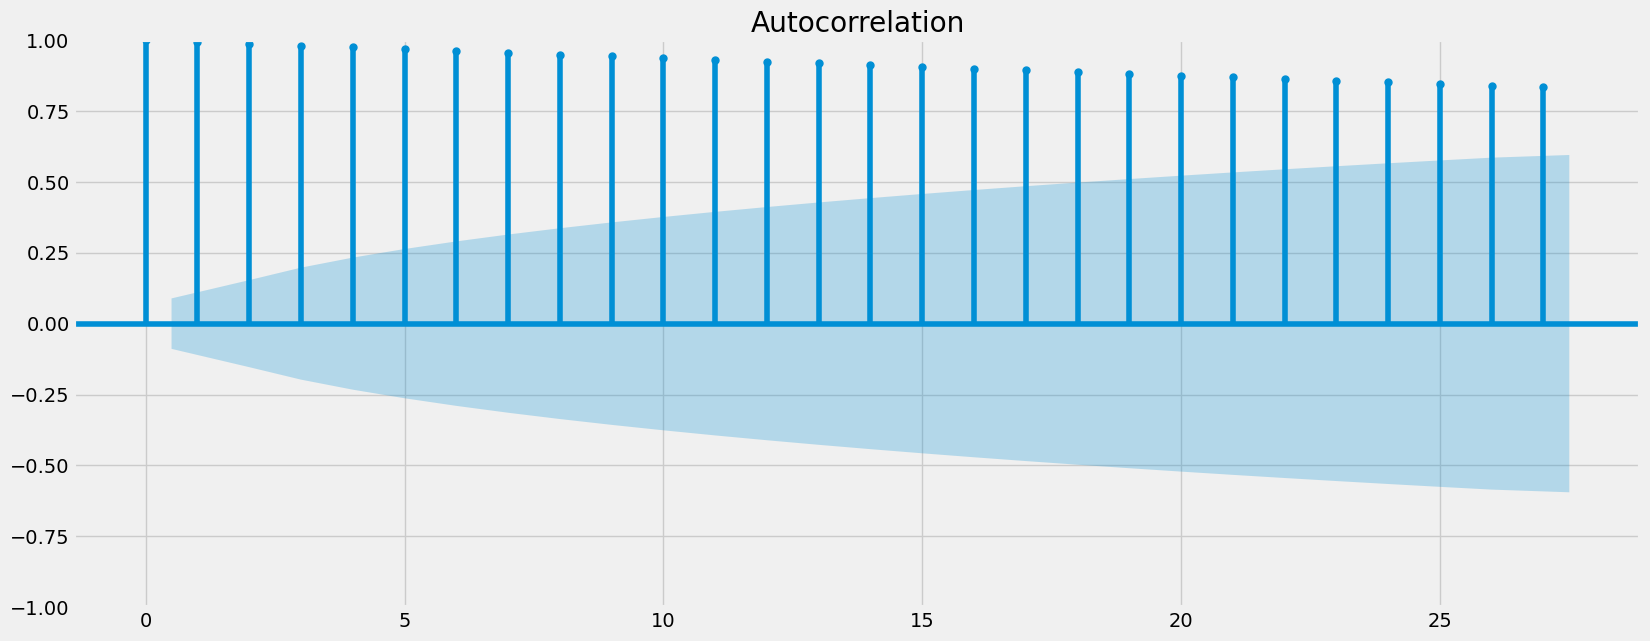

In [43]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_sub)
plt.show()

#### Note:  lags are significantly correlated with each other, which supports the Dickey Fuller test, meaning that the data is non-stationary.

### 5. Stationarizing the Data

In [44]:
data_diff = data_sub - data_sub.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [45]:
data_diff.dropna(inplace = True) # Here, I am removing the missing values that came about as a result of the differencing. 
# need to remove these or won't be able to run the Dickey-Fuller test.

In [46]:
data_diff.head()

,Value
datetime,
1980-02-29,1.1
1980-03-31,1.2
1980-04-30,0.9
1980-05-31,0.8
1980-06-30,0.9


In [47]:
data_diff.columns

Index(['Value'], dtype='object')

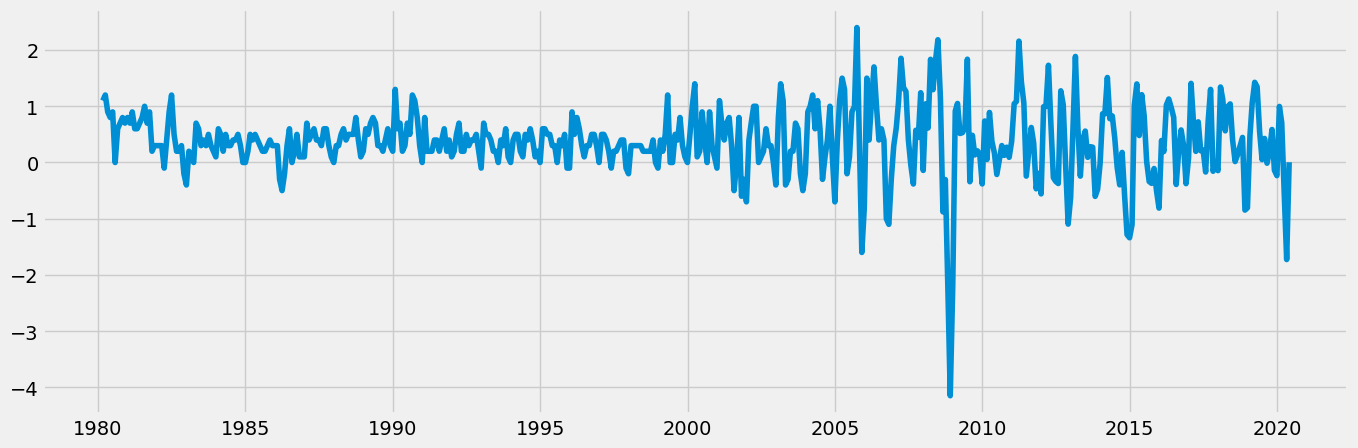

In [48]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [49]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                -6.040578e+00
p-value                        1.349056e-07
Number of Lags Used            1.200000e+01
Number of Observations Used    4.710000e+02
Critical Value (1%)           -3.444310e+00
Critical Value (5%)           -2.867696e+00
Critical Value (10%)          -2.570049e+00
dtype: float64


#### Note: Here we can see that t statistic is now smaller than the critical values.

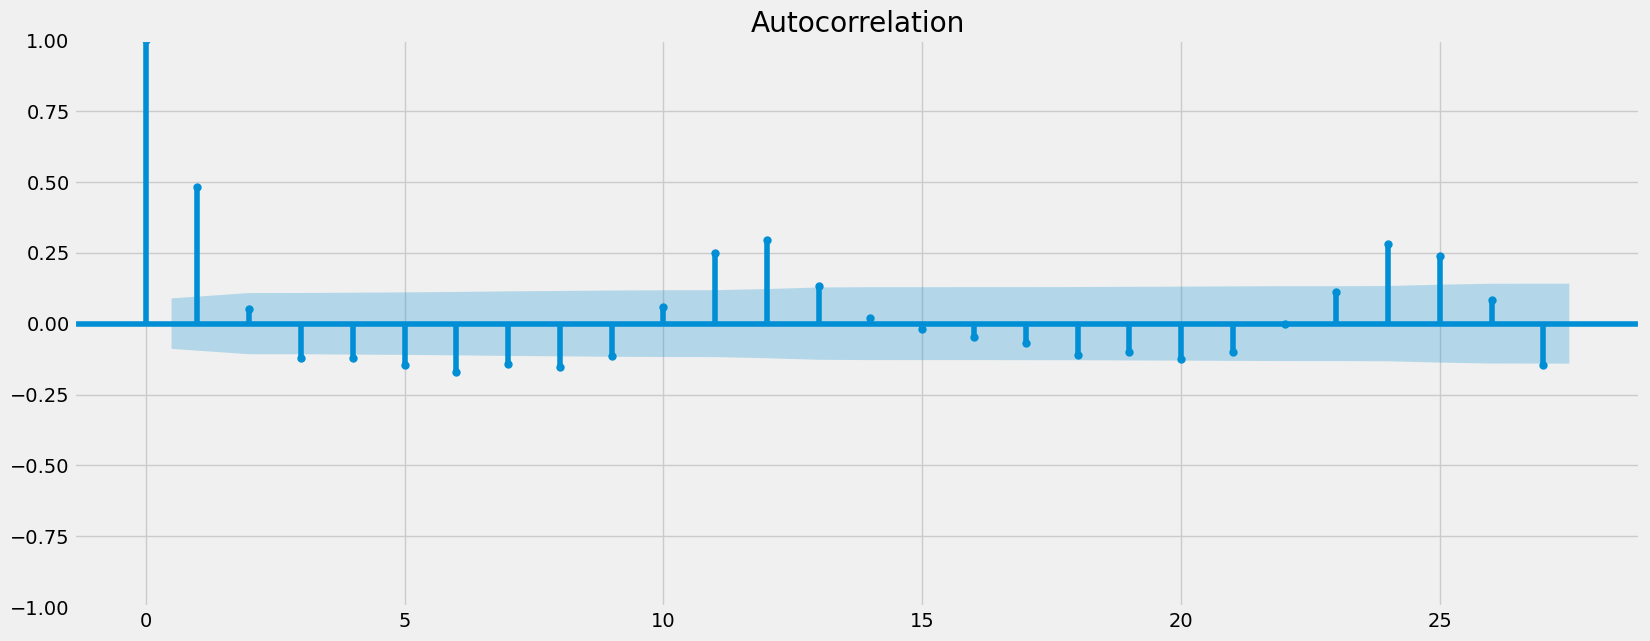

In [50]:
plot_acf(data_diff)
plt.show()

#### Note: there are fewer autocorrelated lags here, which mean the the null hypotheses can be rejected ( data is stationary) and since there are less than 10 autocorrelated lags, I will stop here.